In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import chardet
import os

#### Objetivo
Conseguir un dataframe el cual nos pueda decir que vehiculos hay matriculados en un cierto mes y año.

Para ello necesitamos conocer el parque de vehiculos exacto en un punto inicial y poder saber los cambios respecto a ese punto.

En neustro caso tenemos el fichero del parque de vehiculos "mat_2034.txt" y tenemos todos los tramites desde el dia de hoy hasta diciembre de 2014. Lo que podemos hacer es añadir una columna extra para Año de Matriculación, una para Mes de Matriculación, Año de Baja y Mes de Baja. De manera que si seleccionamos los vehciulos que estan matriculados, por ejemplo, en Abril de 2021 tenemos que seleccionar todos los vehciulos con fecha de baja posterior a abril de 2021 (o sin fecha de baja) y una baja de matriculacion anterior o igual a abril de 2021.

#### Worflow
1. Priemro leemos el fichero de parque de vehciulos y eliminamos todas las columnas que no nso interean.
2. Comprobamos la fehca de matroculación más reciente para saber el punto de partida. (29-12-2023)
3. Tenemos que concatenar los diferentes DataFrames que tenemos sobre tramites de manera que:
    - Tengan las columnas que queremos
    - 4 columnas más: Año Baja | Mes Baja | Año Matr | Mes Matr, para conseguirlo tenemos que clasificar los diferentes tramites como Alta o Matriculacion y extraer la fecha en la que se dio dicho tramite
4. Una vez tenemos concatenados los dataframes de los tramites hay que concatenarlos con la foto exacta del parque
5. Definir una funcion que nos diga los coches en circulación el mes y el año que queramos

### 1. Leer el fichero

In [2]:
def reader(name, sep=',', columns= ['EMISIONES_CO2','FECHA_MATR'], parse_dates=None):
    chunksize = 10**4
    dates_col = parse_dates
    chunkreader = pd.read_csv(name, sep=sep, usecols=columns,chunksize=chunksize, 
                              on_bad_lines='skip', low_memory=False, parse_dates=dates_col) 
    #If bad lines not skipped we get an error bc of different types of data in the same columns
    #Columns (0,1,8,11,12,15,19,20,23,24,25,26,27,30,32,33,37,39,40,41,42,43,44) 

    for chunk in chunkreader:
        yield chunk

In [3]:
path = os.path.join("Data", "DGT")

### 2. Comprobar la fecha más reciente

In [4]:
fechas = []
file = os.path.join(path,"Parque_exacto","mat_2023.txt")
for chunk in reader(file,sep='|'):
    chunk['FECHA_MATR'] = pd.to_datetime(chunk['FECHA_MATR'], errors='coerce', dayfirst=True)
    fechas.append(chunk['FECHA_MATR'].max())

dates = pd.DataFrame({'NEWEST_MATR' : fechas})
newest_matr = dates['NEWEST_MATR'].max()
print(f'La matriculacion más reciente en la foto exacta del parque es del dia {newest_matr}')

La matriculacion más reciente en la foto exacta del parque es del dia 2023-12-29 00:00:00


In [12]:
fechas = []
file = os.path.join(path,"Parque_exacto","mat_2023.txt")
for chunk in reader(file,sep='|'):
    chunk['FECHA_MATR'] = pd.to_datetime(chunk['FECHA_MATR'], errors='coerce', dayfirst=True)
    fechas.extend(chunk['FECHA_MATR'].tolist())

dates = pd.DataFrame({'NEWEST_MATR' : fechas})
newest_matr = dates['NEWEST_MATR'].max()
print(f'La matriculacion más reciente en la foto exacta del parque es del dia {newest_matr}')

La matriculacion más reciente en la foto exacta del parque es del dia 2023-12-29 00:00:00


In [89]:
file = os.path.join(path,"Parque_exacto","mat_2023.txt")
strange_cases = pd.DataFrame({'FECHA_MATR' : [],
                              'FECHA_PRIM_MATR' : []})

for matriculas in (reader(file,sep='|',columns= ['FECHA_PRIM_MATR','FECHA_MATR'])):
    matriculas['FECHA_MATR'] = pd.to_datetime(matriculas['FECHA_MATR'], dayfirst=True)
    matriculas['FECHA_PRIM_MATR'] = pd.to_datetime(matriculas['FECHA_PRIM_MATR'], dayfirst=True)

    filtered_df = matriculas[matriculas['FECHA_PRIM_MATR'] > matriculas['FECHA_MATR']]
    strange_cases = pd.concat([strange_cases,filtered_df], axis=0)

    #if matriculas.FECHA_PRIM_MATR.max().year > 2023:

/var/folders/gk/9s2n71rj4fq128zrj3x599pr0000gn/T/ipykernel_2366/2106594439.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  strange_cases = pd.concat([strange_cases,filtered_df], axis=0)


In [97]:
strange_cases[strange_cases['FECHA_PRIM_MATR'].dt.year == 2025]

,FECHA_MATR,FECHA_PRIM_MATR
2308750,2023-11-17,2025-11-14
7100686,2023-08-04,2025-07-21
32544636,2023-10-20,2025-10-18


### 3. Concatenar los dataframes de tramites

Menuda broma como guardan los ficheros de tramites mensuales.
- Estan codificados con ISO-8859-1
- El fichero no tiene header, nombre de columnas definido en el codigo
- Es un fixed-width file y cada columna ocupa una cantidad diferente, definido en el codigo

Creo que FEC_TRAMITE (y/o FEC_TRAMITACION) indica cuando se hizo el tramite y FEC_PROCESO cuando ese tramite se hizo efectivo. Voy a coger FEC_TRAMITE por ahora

In [670]:
file = os.path.join(path,"bajas","export_mensual_bajas_202501.txt")
with open(file, 'rb') as f:
    result = chardet.detect(f.read(11700))

encoding = result['encoding']
print(f'The encoding of the file is: {encoding}')

col_widths = [8,1,8,30,22,1,21,2,1,5,6,6,6,3,2,2,2,2,24,2,2,1,8,5,8,1,1,9,3,5,30,7,3,5,1,1,1,1,1,1,11,25,25,35,70,6,6,4,4,3,8,4,4,4,6,30,50,35,25,35,4,4,4,1,25,1,4,25,8]
col_names = ["FEC_MATRICULA","COD_CLASE_MAT","FEC_TRAMITACION","MARCA_ITV","MODELO_ITV","COD_PROCEDENCIA_ITV","BASTIDOR_ITV","COD_TIPO",
    "COD_PROPULSION_ITV","CILINDRADA_ITV","POTENCIA_ITV","TARA","PESO_MAX","NUM_PLAZAS","IND_PRECINTO","IND_EMBARGO","NUM_TRANSMISIONES",
    "NUM_TITULARES","LOCALIDAD_VEHICULO","COD_PROVINCIA_VEH","COD_PROVINCIA_MAT","CLAVE_TRAMITE","FEC_TRAMITE","CODIGO_POSTAL","FEC_PRIM_MATRICULACION",
    "IND_NUEVO_USADO","PERSONA_FISICA_JURIDICA","CODIGO_ITV","SERVICIO","COD_MUNICIPIO_INE_VEH","MUNICIPIO","KW_ITV","NUM_PLAZAS_MAX","EMISIONES_CO2","RENTING", 
    "COD_TUTELA", "COD_POSESION","IND_BAJA_DEF","IND_BAJA_TEMP", "IND_SUSTRACCION","BAJA_TELEMATICA","TIPO_ITV","VARIANTE_ITV","VERSION_ITV",
    "FABRICANTE_ITV", "MASA_ORDEN_MARCHA_ITV","MASA_MAXIMA_TECNICA_ADMISIBLE_ITV","CATEGORÍA_HOMOLOGACION_EUROPEA_ITV","CARROCERIA","PLAZAS_PIE",
    "NIVEL_EMISIONES_EURO_ITV","CONSUMO_WH/KM_ITV","CLASIFICACIÓN_REGLAMENTO_VEHICULOS_ITV", "CATEGORÍA_VEHICULO_ELECTRICO","AUTONOMÍA_VEHÍCULO_ELÉCTRICO",
    "MARCA_VEHÍCULO_BASE","FABRICANTE_VEHÍCULO_BASE","TIPO_VEHÍCULO_BASE","VARIANTE_VEHÍCULO_BASE","VERSIÓN_VEHÍCULO_BASE","DISTANCIA_EJES_12_ITV",
    "VIA_ANTERIOR_ITV","VIA_POSTERIOR_ITV","TIPO_ALIMENTACION_ITV","CONTRASEÑA_HOMOLOGACION_ITV","ECO_INNOVACION_ITV","REDUCCION_ECO_ITV","CODIGO_ECO_ITV","FEC_PROCESO"
]

def tramit_reader(file_path,col_widths=col_widths,col_names=col_names, encoding='ISO-8859-1',skipped_row=0):
    df = pd.read_fwf(
        file_path,
        widths=col_widths,
        encoding=encoding,
        header=None,
        skiprows=skipped_row
    )
    df.columns = col_names
    return df

def normalize_date(date_str):
    date_str = str(date_str).strip()
    if len(date_str) == 7:
        return '0' + date_str
    return date_str

#Tengo dudas si el 5 deberia contar como matriculacion
def tramit_checker(df):
    Mat = [1,5,8,9]
    Baja = [0,3,4,6,7]

    clave_tramite = df['CLAVE_TRAMITE'][0]

    if clave_tramite in Baja:
        return df['FEC_TRAMITE']
    else:
        return float("nan")
    
def tramit_proces(df):
    df['FEC_MATRICULA'] = df['FEC_MATRICULA'].apply(normalize_date)
    df['FEC_MATRICULA'] = pd.to_datetime(df['FEC_MATRICULA'], format='%d%m%Y')
    df['FEC_TRAMITE'] = df['FEC_TRAMITE'].apply(normalize_date)
    df['FEC_TRAMITE'] = pd.to_datetime(df['FEC_TRAMITE'], format='%d%m%Y')
    df = pd.concat([df,tramit_checker(df)], axis=1)
    df.columns = ['EMISIONES_CO2','FEC_MATRICULA','CLAVE_TRAMITE','FEC_TRAMITE','FEC_BAJA']
    df = df.drop(['FEC_TRAMITE','CLAVE_TRAMITE','FEC_TRAMITE'], axis=1)
    return df

def matr_proces(df):
    df['FEC_MATRICULA'] = df['FEC_MATRICULA'].apply(normalize_date)
    df['FEC_MATRICULA'] = pd.to_datetime(df['FEC_MATRICULA'], format='%d%m%Y')
    df = df.drop(['FEC_TRAMITE','CLAVE_TRAMITE'], axis=1)
    dummy = pd.DataFrame(np.nan, index=list(range(0,df.shape[0])), columns=['FEC_BAJA'])
    dummy['FEC_BAJA'] = pd.to_datetime(dummy['FEC_BAJA'])
    df = pd.concat([df,dummy], axis=1)
    df.columns = ['EMISIONES_CO2','FEC_MATRICULA','FEC_BAJA']
    return df

The encoding of the file is: ISO-8859-1


#### Bajas

In [ ]:
tramit_path = Path(os.path.join(path,"bajas"))
files = [f.name for f in tramit_path.iterdir() if f.is_file()]
col_to_keep = ['EMISIONES_CO2','FEC_MATRICULA','CLAVE_TRAMITE','FEC_TRAMITE']
col_names = ['EMISIONES_CO2','FEC_MATRICULA','FEC_BAJA']
tramit_file = os.path.join(path,"bajas","bajas.csv")

for x,file in enumerate(files):
    file = os.path.join(path,"bajas",file)
    if x == 0:
        df = tramit_reader(file)
        df = df[col_to_keep]
        procesado = tramit_proces(df)
        procesado.to_csv(tramit_file, mode='w', header=col_names, index=False)
    else:
        df = tramit_reader(file)
        df = df[col_to_keep]
        procesado = tramit_proces(df)
        procesado.to_csv(tramit_file, mode='a', header=False, index=False)

#### Matriculaciones

In [674]:
tramit_path = Path(os.path.join(path,"matr"))
files = [f.name for f in tramit_path.iterdir() if f.is_file()]
col_to_keep = ['EMISIONES_CO2','FEC_MATRICULA','CLAVE_TRAMITE','FEC_TRAMITE']
col_names = ['EMISIONES_CO2','FEC_MATRICULA','FEC_BAJA']
tramit_file = os.path.join(path,"matr","matr.csv")

for x,file in enumerate(files):
    file = os.path.join(path,"matr",file)
    if x == 0:
        df = tramit_reader(file,skipped_row=1)
        df = df[col_to_keep]
        procesado = matr_proces(df)
        procesado.to_csv(tramit_file, mode='w', header=col_names, index=False)
    else:
        df = tramit_reader(file,skipped_row=1)
        df = df[col_to_keep]
        procesado = matr_proces(df)
        procesado.to_csv(tramit_file, mode='a', header=False, index=False)

### 4. Adaptar el fichero de la foto exacta al formato
Del fichero de los tramites tenemos un dataframe que tiene las columnas que queremos (de momento solo la de EMISIONES_CO2 y 4 columnas con mes y año de matriculacion y baja del vehiculo).

In [554]:
col_names = ['EMISIONES_CO2','FEC_MATRICULA','FEC_BAJA']
file = os.path.join(path,"Parque_exacto","mat_2023.txt")
foto_exacta_file = os.path.join(path,"Parque_exacto","foto_exacta.csv")

for x,chunk in enumerate(reader(file,sep='|')):
    chunk = chunk.iloc[:, [1, 0]]
    chunk['FECHA_MATR'] = pd.to_datetime(chunk['FECHA_MATR'], errors='coerce', dayfirst=True)
    df = pd.DataFrame(np.nan, index=list(range(0,chunk.shape[0])), columns=['FEC_BAJA'])
    chunk = pd.concat([chunk,df], axis=1)
    chunk.columns = ['EMISIONES_CO2','FEC_MATRICULA','FEC_BAJA']

    if x == 0:
        chunk.to_csv(foto_exacta_file, mode='w', header=col_names, index=False)
    else:
        chunk.to_csv(foto_exacta_file, mode='a', header=False, index=False)

### 5. Crear funcion que nos diga los coches circulando

El Dataframe exacto está hecho solo hasta diciembre de 2023

---

Si la fecha es posterior a la foto del parque:

A = Seleecione todos los coches que tienen fecha de matriculacion anterior a la fecha (en la foto exacta)

B = Seleccione todos los coches que tienen fecha de matriculacion anterior a la fecha de baja posterior (en las bajas)

B' = Selecciones todos los coches que tienen fecha de matriculacion anterioir a la fecha (en las matriculaciones)

Resultado = A - B + B'

---

Si la foto es anterioir a la foto del parque:

A = Seleecione todos los coches que tienen fecha de matriculacion anterior a la fecha (en la foto exacta)

C = Seleccione todos los tramites de baja que esten entre la fecha y la fecha de la foto exacta

Resultado = A + B

In [101]:
def get_cars(fecha,foto_exacta,baja,matr,fecha_foto):
    '''
    fecha : date on pd.timestamp format from which we want to exctract the info
    foto_exacta : pd.Dataframe with an exact "photo" of the automobilistic park
    baja : pd.Dataframe with all the car retirements we have
    matr : pd.Dataframe with all the car matriculations we have
    fecha_foto : date on pd.timestamp format of when the foto_exacta was taken
    '''
    A = foto_exacta[foto_exacta['FEC_MATRICULA'] <= fecha]

    if fecha >= fecha_foto:
        B = matr[
            (matr['FEC_MATRICULA'] > fecha_foto) &
            (matr['FEC_MATRICULA'] <= fecha) #&
            #((matr['FEC_BAJA'].isnull()) | (matr['FEC_BAJA'] > fecha))
        ]

        C = baja[
            (baja['FEC_BAJA'] >= fecha_foto) &
            (baja['FEC_BAJA'] <= fecha) &
            (baja['FEC_MATRICULA'] <= fecha_foto)
        ] 
    
        emisiones = (A['EMISIONES_CO2'].sum() +
                     B['EMISIONES_CO2'].sum() -
                     C['EMISIONES_CO2'].sum())
        
        return emisiones

    else:
        C = baja[
            #(baja['FEC_MATRICULA'] <= fecha) &
            (baja['FEC_BAJA'] >= fecha) & 
            (baja['FEC_BAJA'] <= fecha_foto)
        ]

        emisiones = (A['EMISIONES_CO2'].sum() +
                     C['EMISIONES_CO2'].sum())
        
        return emisiones

In [99]:
DateOffset = pd.tseries.offsets.DateOffset
date = pd.to_datetime('2025-02-01')
dates = []
#'2022-10-01'
while date > pd.to_datetime('2022-10-01'):
    dates.append(date)
    date = date - DateOffset(months=1)

In [103]:
dummy_df = pd.DataFrame(columns=['EMISIONES_CO2', 'FEC_MATRICULA', 'FEC_BAJA'])
dummy_df['FEC_BAJA'] = pd.to_datetime(dummy_df['FEC_BAJA'])
dummy_df['FEC_MATRICULA'] = pd.to_datetime(dummy_df['FEC_MATRICULA'])
emisions = []
fecha_foto = pd.to_datetime('2023-12-29 00:00:00')

foto_exacta_file = os.path.join(path,"Parque_exacto","foto_exacta.csv")
tramit_file = os.path.join(path,"matr","matr.csv")
col_names = ['EMISIONES_CO2','FEC_MATRICULA','FEC_BAJA']

for date in dates:
    emision = 0

    for chunk in (reader(foto_exacta_file,columns=col_names,parse_dates=[1, 2])):
        emision += get_cars(date,chunk,dummy_df,dummy_df,fecha_foto)

    for chunk in (reader(tramit_file,columns=col_names,parse_dates=[1, 2])):
        emision += get_cars(date,dummy_df,chunk,dummy_df,fecha_foto)

    for chunk in (reader(tramit_file,columns=col_names,parse_dates=[1, 2])):
        emision += get_cars(date,dummy_df,dummy_df,chunk,fecha_foto)
        
    emisions.append(emision)

results = {
    'Date' : dates,
    'Emisions' : emisions
}
results = pd.DataFrame(results)
results.to_csv('results2.csv')

/var/folders/gk/9s2n71rj4fq128zrj3x599pr0000gn/T/ipykernel_2366/4013675395.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


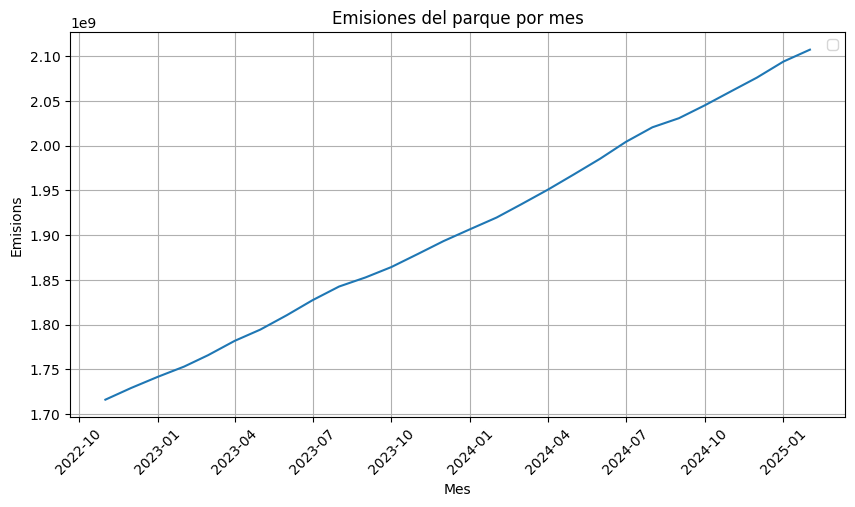

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(dates, emisions, linestyle='-')

plt.xlabel("Mes")
plt.ylabel("Emisions")
plt.title("Emisiones del parque por mes")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

In [704]:
results = {
    'Date' : dates,
    'Emisions' : emisions
}
results = pd.DataFrame(results)
results.to_csv('results.csv')